In [1]:
import math
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import heapq # for retrieval topK
import multiprocessing
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
from pprint import pprint 
from time import time
from scipy.sparse.linalg import svds, eigs
%matplotlib inline

# Load in log data and clean it 

In [2]:
for root,dirs,files in os.walk('.'):
    pprint(files)
    file_list = files
df_etu_log = pd.read_csv('etu_log.csv', engine = 'python',error_bad_lines=False)

['Negative_test_rating_19N.txt',
 'etu_log.csv',
 'Content-based.ipynb',
 'Negative_test_rating_199N.txt',
 'README.md',
 'doc2_conversion_table.csv',
 'cw-article.csv',
 'doc1_viewing_columnExp.csv',
 'doc1_viewing_history_cateID.csv',
 'article_contents.csv',
 'doc3_post_and_clicks.csv',
 'DailyPost.csv',
 'Negative_test_rating_50N.txt',
 'EDA.ipynb',
 'doc2_conversion_reference.csv',
 'CF.ipynb',
 'Negative_test_rating_99N.txt',
 'doc1_viewing_data.csv']
['output.json',
 'optimization_test.py',
 'multilingual.md',
 'LICENSE',
 'bert_train_data.ipynb',
 'input.txt',
 'tokenization.py',
 'create_pretraining_data.py',
 'README.md',
 'optimization.py',
 'run_pretraining.py',
 'extract_features.py',
 'requirements.txt',
 'tokenization_test.py',
 'chinese_L-12_H-768_A-12.zip',
 'run_classifier.py',
 'run_squad.py',
 'sample_text.txt',
 'bert_dev.p',
 '__init__.py',
 'run_classifier_with_tfhub.py',
 'CONTRIBUTING.md',
 'bert_train.p',
 'modeling.py',
 'modeling_test.py',
 '.gitignore']
['v

Skipping line 4359075: unexpected end of data


In [3]:
df_etu_log.head()

,time,act,cat,pid,eruid,keywords,url,hostname,agent,predn,preurl,lo,ssid,paywall,dates,eturec
0,00:00:02,view,79.0,5088277.0,375b2a4d-6b06-c1aa-1cf6-a9472e820d65,NaN,https://www.cw.com.tw/article/article.action?i...,www.cw.com.tw,Mozilla/5.0 (Linux; Android 6.0.1; HTC_D10u Bu...,m.facebook.com,http://m.facebook.com/,0.0,8fa8df160d30,NaN,2018-02-18,NaN
1,00:00:01,view,11.0,5087710.0,1be09de3-2363-1350-b095-221d37445280,NaN,https://www.cw.com.tw/article/article.action?i...,www.cw.com.tw,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_5 like...,m.facebook.com,http://m.facebook.com,0.0,c0430e760562,NaN,2018-02-18,NaN
2,00:00:02,view,85.0,5088005.0,ced1cce8-08cc-0e84-82ec-b1b1ce6f32a0,NaN,https://www.cw.com.tw/article/article.action?i...,www.cw.com.tw,Mozilla/5.0 (iPhone; CPU iPhone OS 10_3_1 like...,m.facebook.com,http://m.facebook.com,0.0,eed333bf3ef0,NaN,2018-02-18,NaN
3,00:00:02,view,11.0,5088180.0,bde6bba0-bd52-e4b3-a17b-18cd72b02214,NaN,https://www.cw.com.tw/article/article.action?i...,www.cw.com.tw,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_5 like...,m.facebook.com,http://m.facebook.com,0.0,bb8b100b1fad,NaN,2018-02-18,NaN
4,00:00:01,view,7.0,5081463.0,bb652779-3133-e1ec-5914-24d902b70197,NaN,https://www.cw.com.tw/article/article.action?i...,www.cw.com.tw,Mozilla/5.0 (Linux; Android 6.0.1; CPH1611 Bui...,www.google.com.tw,https://www.google.com.tw/,0.0,228acfd7c345,NaN,2018-02-18,NaN


In [4]:
def del_df_columns_list(df,column_name,name_list,way_is_1=True):
    
    """
    it can only delete one columns once 
    """
    if way_is_1 == True:
        for i in name_list:
            df = df[df[column_name] != i]
    else:
    #     below is the pd.merge way to merge data, but sometime coz pd will mislead the columns due to dtypes
    #     If using the merge way, we should get the list that we want to PERSERVE.    
        d = pd.DataFrame(data = name_list, columns = [column_name])
        df = pd.merge(df, d, how = 'inner', on = [column_name])
    
    return df




print('start preprocessing')
### Delete the unique user with click time less than 2, for 1 clicking user for CF-model is useless
del_list = df_etu_log.eruid.value_counts()[(df_etu_log.eruid.value_counts() > 2) & (df_etu_log.eruid.value_counts() < 90*50)].keys()
df_etu_log = del_df_columns_list(df_etu_log,'eruid',del_list,way_is_1 = False)
print('Done_1,df_shape is :',df_etu_log.shape)
### Drop the na-value in pid,eruid
df_etu_log = df_etu_log.dropna(subset = ['pid','eruid'],how = 'any')
print('Done_2,df_shape is :',df_etu_log.shape)
### The time format should be like '**-**-**', so we filter out those length not equal to 8.
del_list = list(set([i for i in df_etu_log.time if len(i)!=8])) 
df_etu_log = del_df_columns_list(df_etu_log,'time',del_list)
print('Done_3,df_shape is :',df_etu_log.shape)
### Creating the column using both time and date
df_etu_log['datetime'] = df_etu_log['dates'] +'-'+ df_etu_log['time']
print('Done_4,df_shape is :',df_etu_log.shape)

start preprocessing
Done_1,df_shape is : (2154549, 16)
Done_2,df_shape is : (1993796, 16)
Done_3,df_shape is : (1993796, 16)
Done_4,df_shape is : (1993796, 17)


# Metrics Definition

In [5]:
### Hit rate / NDCG
### reference : https://www.comp.nus.edu.sg/~xiangnan/papers/cikm15-trirank-cr.pdf

def getHitRatio(ranklist, gtItem):
    if gtItem in ranklist:
        return 1
    return 0

def getNDCG(ranklist, gtItem):
    ar = np.array(ranklist)
    if gtItem in ar:
        return math.log(2) / math.log(np.where(ar == gtItem)[0][0] + 2)
    return 0

In [6]:
def eval_one_rating(idx, eval_mode,uim):
    
    '''''
    eval_mode = 'Keras', 'ALS', 'matrix'
    '''''
    rating = _testRatings[idx]
    ### rating should be like (  [user_id,article_pid(only one article, which is ground truth)]  ) 
    items = _testNegatives[idx][1]
    ### items should be like (  [article_pid(19 ones, which are ones the reader haven't read)]  )
    u = rating[0]
    gtItem = rating[1]
    items.append(gtItem)
    
    # Get prediction scores, the process is we offer 100(99 negative + 1 ground truth) articles to one user in testing data, and predict the score(read or not) and ranking.
    map_item_score = {}
    users = np.full(len(items), u, dtype = 'int32')
    
    if eval_mode == 'ALS':
        predictions = _model.rank_items(u, uim.T, items)
        items.pop()
        ranklist = np.array(predictions, dtype = int)[:_K,0]
        
    else:
        if eval_mode == 'Keras':
            predictions = _model.predict([users, np.array(items)], 
                                         batch_size=100, verbose=0)
        elif eval_mode == 'matrix':         
            predictions = _model[u,items]


        for i in range(len(items)):
            item = items[i]
            map_item_score[item] = predictions[i]
        items.pop()
        
        # Evaluate top rank list
        ranklist = heapq.nlargest(_K, map_item_score, key=map_item_score.get)
        
    hr = getHitRatio(ranklist, gtItem)
    ndcg = getNDCG(ranklist, gtItem)
    return (hr, ndcg)

In [7]:
# Global variables that are shared across processes
_model = None
_testRatings = None
_testNegatives = None
_K = None

def evaluate_model(model, testRatings, testNegatives, K, num_thread, eval_mode = 'Keras', uim =None):
    """
    Evaluate the performance (Hit_Ratio, NDCG) of top-K recommendation
    Return: score of each test rating.
    """
    global _model
    global _testRatings
    global _testNegatives
    global _K
    _model = model
    _testRatings = testRatings
    _testNegatives = testNegatives
    _K = K
        
    hits, ndcgs = [],[]
    if(num_thread > 1): # Multi-thread
        pool = multiprocessing.Pool(processes=num_thread)
        res = pool.map(eval_one_rating, range(len(_testRatings)))
        pool.close()
        pool.join()
        hits = [r[0] for r in res]
        ndcgs = [r[1] for r in res]
        return (hits, ndcgs)
    else:# Single thread
        for idx in range(len(_testRatings)):
            (hr,ndcg) = eval_one_rating(idx, eval_mode, uim)
            hits.append(hr)
            ndcgs.append(ndcg)      
    return (hits, ndcgs)

# Training Testing Split

#### In this section, I hope that I don't just randomly split the training/testing sets into 9:1.
#### Rather, I will select those users with over 5 click times and pick the last click as the testing set.
#### For example, index 1354 user has following reading history:{2,364,8796,4511,5,64}.
#### This user history for {2,364,8796,4511,5} will be viewed as training set and 64 will be testing.
#### Here testing means 1354 user did click into the article 64, and If the recommendation system provides the article in the recommending list, it means it succeed.

In [8]:
def train_test_split_time(df , columns_1 , columns_2 , columns_time , ratio = 0.9):
    '''
    we will use the columns_1 as the first level index
    sort the columns_2 as the target by columns_time
    '''
    
    retreive_name = df[columns_1].value_counts()[df[columns_1].value_counts()>5].keys()
    df_test = df[df[columns_1].isin(retreive_name)]
    df_test = df_test.sort_values(columns_time).groupby(columns_1).tail(1)
    df_train = df.drop(index=df_test.index)
    
    if df_test.shape[0] + df_train.shape[0] == df.shape[0]:
        print('train_test_split succeed!! with df_train shape:(%d,%d), df_test shape:(%d,%d)'
              %(df_train.shape[0],df_train.shape[1],df_test.shape[0],df_test.shape[1])
             )
        return df_train, df_test, retreive_name
    else:
        print('Oops, something wrong, with df_train shape : (%d,%d), df_test shape : (%d,%d)'
              %(df_train.shape[0],df_train.shape[1],df_test.shape[0],df_test.shape[1])
             )
        print('df_shape : (%d,%d)'
              %(df.shape[0],df.shape[1])
             )

In [9]:
df_train,df_test, retrieve = train_test_split_time(df_etu_log,'eruid','pid','datetime')

train_test_split succeed!! with df_train shape:(1894191,17), df_test shape:(99605,17)


#### We will use the leave-one-out method to evaluate our testing data
#### Basically, we will generate N samples list that the test user hasn't read and add the ground truth into the list, and see how the recommendation system will score and rank the list

In [10]:
def get_sampling(df_target,df_source,numbers_of_N_sample, generate_negative = False):
    '''
    1.
    return: test_rating in the shape of [ [user_pid,article] *99605 ]
    2.
    from the target dataframe, sampling the negative sample from source dataframe
    return: list in the shape of [ [(2(user_id,ground truth)) , [19(negative samples)] ]*99605]
    '''
    
    test_rating = df_target[['eruid','pid']].values.tolist()
    
    print('test_rating yield successfully!!!')
    
    if generate_negative == True:
        df_temp = df_source.drop_duplicates(subset = 'pid', keep = 'first')
        negative_test_rating = []
        for i in range(df_target.shape[0]):
            drop_id = test_rating[i][0]
            list_ = df_temp[df_temp['eruid'] != drop_id]['pid'].sample(numbers_of_N_sample).values.tolist()
            
            negative_test_rating.append([test_rating[i],list_])
        print('negative_test_rating yield successfully!!!')

        return test_rating, negative_test_rating
    else:
        return test_rating

In [11]:
print('''only for generating sample, if there is a sample file already, skip this cell in the future''')
### In the future just execute the next cell to get the test rating & negative sampling

# time1 = time()
# test_rating, negative_test_rating = get_sampling(df_test,df_train,19,True)
# time2 = time()
# print('Took for %d seconds' %(time2-time1))
# with open("Negative_test_rating_19N.txt","wb") as f: #in write mode
#     pickle.dump(negative_test_rating,f)

    
# ### For the simple model already kill(98% Hit Ratio) the dataset, so let's make it a bit harder
# time1 = time()
# test_rating, negative_test_rating = get_sampling(df_test,df_train,99,True)
# time2 = time()
# print('Took for %d seconds' %(time2-time1))
# with open("Negative_test_rating_99N.txt","wb") as f: #in write mode
#     pickle.dump(negative_test_rating,f)

    
### Experiment on my theory: whether the N samples in hit ratio is a parameters that needs to tune
# time1 = time()
# test_rating, negative_test_rating = get_sampling(df_test,df_train,199,True)
# time2 = time()
# print('Took for %d seconds' %(time2-time1))
# with open("Negative_test_rating_199N.txt","wb") as f: #in write mode
#     pickle.dump(negative_test_rating,f)
    

only for generating sample, if there is a sample file already, skip this cell in the future


In [12]:
time1 = time()
test_rating = get_sampling(df_test,df_train,None)
with open("Negative_test_rating_199N.txt",'rb') as f: #in read mode, not in write mode, careful
    negative_test_rating = pickle.load(f)
    print('negative_test_rating yield successfully!!!')
time2 = time()
print('Took for %d seconds' %(time2-time1))

test_rating yield successfully!!!
negative_test_rating yield successfully!!!
Took for 4 seconds


In [13]:
# def test_get_sampling(df_target,df_source, generate_negative = False):
#     '''
#     1.
#     return: test_rating in the shape of [ [user_pid,article] *99605 ]
#     2.
#     from the target dataframe, sampling the negative sample from source dataframe
#     return: list in the shape of [ [(2(user_id,ground truth)) , [19(negative samples)] ]*99605]
#     '''
    
#     test_rating = df_target[['eruid','pid']].values.tolist()
    
#     print('test_rating yield successfully!!!')
    
#     if generate_negative == True:
#         df_temp = df_source.drop_duplicates(subset = 'pid', keep = 'first')
#         negative_test_rating = []
#         for i in range(df_target.shape[0]):
#             drop_id = test_rating[i][0]
#             list_ = df_temp[df_temp['eruid'] != drop_id]['pid'].values.tolist()
            
#             negative_test_rating.append([test_rating[i],list_])
#         print('negative_test_rating yield successfully!!!')

#         return test_rating, negative_test_rating
#     else:
#         return test_rating
    
# time1 = time()
# test_rating, negative_test_rating = test_get_sampling(df_test,df_train,True)
# time2 = time()
# print('Took for %d seconds' %(time2-time1))
# with open("Negative_test_rating_allN.txt","wb") as f: #in write mode
#     pickle.dump(negative_test_rating,f)

# Keras Matrix Factorization

In [14]:
### In this part, we will first make the matrix to be like 1 for read once 0 for never-read 
df_train['read_time'] = 1
df_test['read_time'] = 1
df_train_group = df_train[['eruid','pid','read_time']].groupby(by = ['eruid','pid'],as_index=False).sum()
df_test_group = df_test[['eruid','pid','read_time']].groupby(by = ['eruid','pid'],as_index=False).sum()

### For the reason that normally people don't read articles more than 10 times
cliper = 10
df_train_group['read_time'] = df_train_group['read_time'].apply(lambda w: min(cliper,w))


### To feed into the keras model, we have to turn both the eruid and pid into integer index
eruid_map = {i:v for i,v in enumerate(df_etu_log.eruid.unique())}
inverse_eruid_map = {v:i for i,v in enumerate(df_etu_log.eruid.unique())}
pid_map = {i:v for i,v in enumerate(df_etu_log.pid.unique())}
inverse_pid_map = {v:i for i,v in enumerate(df_etu_log.pid.unique())}

In [15]:
df_train_group.head()

,eruid,pid,read_time
0,00002400-4800-5264-2ee9-bd655a0a91cd,5082394.0,1
1,00002400-4800-5264-2ee9-bd655a0a91cd,5087575.0,1
2,00003620-4c40-2906-33ad-26cb9d5fe178,5053327.0,1
3,00003620-4c40-2906-33ad-26cb9d5fe178,5055570.0,1
4,00003620-4c40-2906-33ad-26cb9d5fe178,5068161.0,1


In [16]:
### creating a mapping table for training data
df_train_group_map = df_train_group.copy()
df_test_group_map = df_test_group.copy()
df_train_group_map['eruid'] = df_train_group['eruid'].map(inverse_eruid_map)
df_train_group_map['pid'] = df_train_group['pid'].map(inverse_pid_map)
df_test_group_map['eruid'] = df_test_group['eruid'].map(inverse_eruid_map)
df_test_group_map['pid'] = df_test_group['pid'].map(inverse_pid_map)

### creating a mapping list for testing data   
test_rating_map = []
for i in range(len(test_rating)):
    test_rating_map.append([inverse_eruid_map[test_rating[i][0]],inverse_pid_map[test_rating[i][1]]])


### creating a mapping list for negative testing data
negative_test_rating_map = []
for i in range(len(negative_test_rating)):
    negative_test_rating_map.append([
                                     [inverse_eruid_map[negative_test_rating[i][0][0]],inverse_pid_map[negative_test_rating[i][0][1]]],
                                     list(map(lambda w:inverse_pid_map[w],negative_test_rating[i][1]))])

In [17]:
print('df_train_group_map shape: ',df_train_group_map.shape)
print('number of users: ', len(eruid_map.items()))
print('number of items: ', len(pid_map.items()))
print('The sparse matrix is one with shape (%d , %d), with %d non-zero read_times'
      %(len(eruid_map.items()),len(pid_map.items()),df_train_group_map.shape[0]))


df_train_group_map shape:  (1555002, 3)
number of users:  368598
number of items:  19988
The sparse matrix is one with shape (368598 , 19988), with 1555002 non-zero read_times


In [18]:
from keras.models import Model
from keras.layers import Input
from keras.layers.core import Reshape, Flatten
from keras.layers.merge import Multiply, multiply, Concatenate
from keras.layers.merge import Dot
from keras.layers.embeddings import Embedding
from keras import optimizers
from keras.regularizers import l2
from keras import initializers
from keras.optimizers import Adagrad, Adam, SGD, RMSprop, Adadelta
from keras import backend as K

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
def get_model(num_users, num_items, latent_dim, regs=[0,0]):
    ### define placeholder.
    user_id_input = Input(shape=[1], name='user')
    item_id_input = Input(shape=[1], name='item')

    ### define embedding size and layers.

    user_embedding = Embedding(output_dim = latent_dim, input_dim = num_users,
                               input_length=1, name='user_embedding',
                               embeddings_regularizer = l2(regs[0]))(user_id_input)
    item_embedding = Embedding(output_dim = latent_dim, input_dim = num_items,
                               input_length=1, name='item_embedding',
                              embeddings_regularizer = l2(regs[1]))(item_id_input)

    user_vecs = Reshape([latent_dim])(user_embedding)
    item_vecs = Reshape([latent_dim])(item_embedding)

    ### The prediction, which we calculate the loss function with ground truth and optimize.
    y_hat = Dot(1, normalize=False)([user_vecs, item_vecs])

    model = Model(inputs=[user_id_input, item_id_input], outputs=y_hat)
    
    return model

In [18]:
num_users = len(eruid_map.items())
num_items = len(pid_map.items())
topK = 5
verbose = 0
latent_dim = 15
epochs = 100
batch_size = 4096
evaluation_threads = 1
best_hr, best_ndcg, best_iter = -1, -1, -1
model_out_file = 'models/GMF_%d_%d.h5' %(latent_dim, time())
testRatings, testNegatives = test_rating_map, negative_test_rating_map
learning_rate = 0.001
model = get_model(num_users, num_items, latent_dim, regs=[0,0])
model.compile(optimizer=Adam(lr=learning_rate), loss='mse') ### In this task, for label is 'read times'(integers from 0 -> 3XXX), so we use MSE as loss to optimize,
                                                            ### However, if there is 'read or not-read'(integers 0 and 1), we should use 'binary cross-entropy'
                                                            ### P.S. If using 'binary cross-entropy' in 'read times' task, I get the weird result with negative l
hr_list = []
loss_list = []
patience = 5
early_stop =True


# Generate training instances
user_input, item_input, labels = df_train_group_map.eruid, df_train_group_map.pid, df_train_group_map.read_time

for epoch in range(epochs):
    t1 = time()
        
    # Training
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                         np.array(labels), # labels 
                         batch_size = batch_size,
                         validation_data = ( [df_test_group_map.eruid,df_test_group_map.pid],df_test_group_map.read_time) ,
                         epochs = 1, verbose = verbose, shuffle = True)
    t2 = time()
        
    # Evaluation
    (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
    hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['val_loss'][0]    
    hr_list.append(hr)
    loss_list.append(loss)
    # Using patience to set the early stopping.
    # Always to save the model with minimun loss.
    if hr < np.max(hr_list):
        patience_count += 1
    else:
        patience_count = 0
        best_hr, best_ndcg, best_iter = hr, ndcg, epoch
        model.save_weights(model_out_file, overwrite=True)
    if (early_stop) and (patience_count == patience):
        break
    if epoch % 1 == 0:
        print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, val_loss = %.4f [%.1f s]' 
            % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
        
print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))

Iteration 0 [5.2 s]: HR = 0.3853, NDCG = 0.2763, val_loss = 0.9808 [112.1 s]
Iteration 1 [1.9 s]: HR = 0.6540, NDCG = 0.4681, val_loss = 0.4131 [112.4 s]
Iteration 2 [1.9 s]: HR = 0.6675, NDCG = 0.4808, val_loss = 0.1149 [112.2 s]
Iteration 3 [1.9 s]: HR = 0.6564, NDCG = 0.4597, val_loss = 0.0897 [111.4 s]
Iteration 4 [1.9 s]: HR = 0.6151, NDCG = 0.4232, val_loss = 0.1025 [111.7 s]
Iteration 5 [1.9 s]: HR = 0.5762, NDCG = 0.3945, val_loss = 0.1304 [110.7 s]
Iteration 6 [1.9 s]: HR = 0.5438, NDCG = 0.3715, val_loss = 0.1669 [110.8 s]
End. Best Iteration 2:  HR = 0.6675, NDCG = 0.4808. 


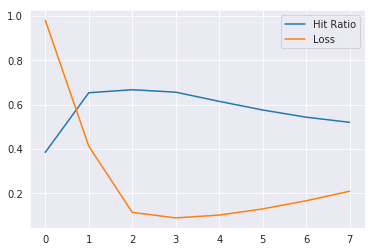

In [19]:
sns.set_style('darkgrid')
plt.plot(hr_list, label = 'Hit Ratio')
plt.plot(loss_list, label = 'Loss')
plt.legend()

In [20]:
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
# from keras.utils import plot_model
# from keras.callbacks import ModelCheckpoint
# # import pydot
# SVG(model_to_dot(model).create(prog='dot', format='svg'))

# Keras Non-negative Matrix Factorization

In [21]:
from keras.constraints import non_neg

def get_NMF_model(num_users, num_items, latent_dim, regs=[0,0]):
    ### define placeholder.
    user_id_input = Input(shape=[1], name='user')
    item_id_input = Input(shape=[1], name='item')

    ### define embedding size and layers.

    user_embedding = Embedding(output_dim = latent_dim, input_dim = num_users,
                               input_length=1, name='user_embedding_NMF', embeddings_constraint = non_neg(),
                               embeddings_regularizer = l2(regs[0]))(user_id_input)
    item_embedding = Embedding(output_dim = latent_dim, input_dim = num_items,
                               input_length=1, name='item_embedding_NMF', embeddings_constraint = non_neg(),
                              embeddings_regularizer = l2(regs[1]))(item_id_input)

    user_vecs = Reshape([latent_dim])(user_embedding)
    item_vecs = Reshape([latent_dim])(item_embedding)

    ### The prediction, which we calculate the loss function with ground truth and optimize.
    y_hat = Dot(1, normalize=False)([user_vecs, item_vecs])

    model = Model(inputs=[user_id_input, item_id_input], outputs=y_hat)
    
    return model

In [22]:
num_users = len(eruid_map.items())
num_items = len(pid_map.items())
topK = 5
verbose = 0
latent_dim = 15
epochs = 100
batch_size = 4096
evaluation_threads = 1
best_hr, best_ndcg, best_iter = -1, -1, -1
model_out_file = 'models/NMF_%d_%d.h5' %(latent_dim, time())
testRatings, testNegatives = test_rating_map, negative_test_rating_map
learning_rate = 0.001
model = get_NMF_model(num_users, num_items, latent_dim, regs=[0,0])
model.compile(optimizer=Adam(lr=learning_rate), loss='mse') ### In this task, for label is 'read times'(integers from 0 -> 3XXX), so we use MSE as loss to optimize,
                                                            ### However, if there is 'read or not-read'(integers 0 and 1), we should use 'binary cross-entropy'
                                                            ### P.S. If using 'binary cross-entropy' in 'read times' task, I get the weird result with negative l
hr_list = []
patience = 5
early_stop =True


# Generate training instances
user_input, item_input, labels = df_train_group_map.eruid, df_train_group_map.pid, df_train_group_map.read_time

for epoch in range(epochs):
    t1 = time()
        
    # Training
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                         np.array(labels), # labels 
                         validation_data = ( [df_test_group_map.eruid,df_test_group_map.pid],df_test_group_map.read_time) ,
                         batch_size = batch_size,
                         epochs = 1, verbose = verbose, shuffle = True)
    t2 = time()
        
    # Evaluation
    (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
    hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['val_loss'][0]    
    hr_list.append(hr)
    # Using patience to set the early stopping.
    # Always to save the model with minimun loss.
    if hr < np.max(hr_list):
        patience_count += 1
    else:
        patience_count = 0
        best_hr, best_ndcg, best_iter = hr, ndcg, epoch
        model.save_weights(model_out_file, overwrite=True)
    if (early_stop) and (patience_count == patience):
        break
    if epoch % 1 == 0:
        print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f,val_loss = %.4f [%.1f s]' 
            % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
        
print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))

Iteration 0 [5.5 s]: HR = 0.6480, NDCG = 0.4604,val_loss = 0.4455 [107.8 s]
Iteration 1 [2.0 s]: HR = 0.6602, NDCG = 0.4740,val_loss = 0.0863 [106.7 s]
Iteration 2 [2.0 s]: HR = 0.6527, NDCG = 0.4507,val_loss = 0.0815 [106.7 s]
Iteration 3 [2.0 s]: HR = 0.6314, NDCG = 0.4151,val_loss = 0.1038 [106.7 s]
Iteration 4 [2.0 s]: HR = 0.6036, NDCG = 0.3821,val_loss = 0.1331 [106.8 s]
Iteration 5 [2.0 s]: HR = 0.5707, NDCG = 0.3522,val_loss = 0.1641 [106.6 s]
End. Best Iteration 1:  HR = 0.6602, NDCG = 0.4740. 


# Scipy Singular Value Decomposition

In [27]:
# For I've tried Tensorflow tf.svd, but it quickly OOM when using
# I've also tried 'surprise' API, but its method 'predict' returns weird value so I couldn't calculate hr/ndcg

### To build the user-item(-rating) matrix(uim) for SVD and evaluate the predicted matrix
topK = 5
verbose = 0
evaluation_threads = 1
nb_users = len(eruid_map.items())
nb_articles = len(pid_map.items())
nb_factors = 15
model_out_file = 'models/SVD_%d_%d.h5' %(nb_factors, time())
uim = np.zeros((nb_users, nb_articles), dtype=np.float32)
uim[df_train_group_map.eruid, df_train_group_map.pid] = df_train_group_map.read_time

time_1 = time()
### From here, we use scipy.sparse.linalg.svds to decompose the uim matrix into U, S, Vt matrix.
### k parameters stand for how many 'ranks'(signular values) we want to preserve. 
U, S, Vt = svds(uim, k = nb_factors)
S_mat = np.diag(S)
rating_matrix_hat = U@S_mat@Vt

print('SVD with U shape:(%d,%d), S_mat shape:(%d,%d), Vt shape:(%d,%d), [%.1f s]'
      %(U.shape[0],U.shape[1],S_mat.shape[0],S_mat.shape[1],Vt.shape[0],Vt.shape[1], time()-time_1)
     )

### Evaluating
testRatings, testNegatives = test_rating_map, negative_test_rating_map
time1 = time()
(hits, ndcgs) = evaluate_model(rating_matrix_hat, testRatings, testNegatives, topK, evaluation_threads,
                               eval_mode = 'matrix')
hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()

print('HR = %.4f, NDCG = %.4f [%.1f s]' % (hr, ndcg, time()-time1))

SVD with U shape:(368598,15), S_mat shape:(15,15), Vt shape:(15,19988), [57.7 s]
HR = 0.6491, NDCG = 0.4725 [9.9 s]


# Keras Neural Matrix Factorization (Neural CF)

In [18]:
from keras.layers import Dense
def init_normal(shape,name=None):
    return initializers.VarianceScaling(scale=0.01, mode='fan_in', distribution='normal')(shape)

def get_NeuralMF_model(num_users, num_items, latent_dim, layers_units ,regs=[0,0], reg_layers = [0,0]):
    ### define placeholder.
    num_layer = len(layers_units) #Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype= 'int32', name='user_input')
    item_input = Input(shape=(1,), dtype= 'int32', name='item_input')
    
    # Embedding layer
    MF_Embedding_User = Embedding(input_dim=num_users, output_dim=latent_dim, name='mf_embedding_user',
                                  embeddings_initializer = init_normal, embeddings_regularizer = l2(regs[0]), input_length=1)(user_input)
    MF_Embedding_Item = Embedding(input_dim=num_items, output_dim=latent_dim, name='mf_embedding_item',
                                  embeddings_initializer = init_normal, embeddings_regularizer =l2(regs[0]), input_length=1)(item_input) 

    MLP_Embedding_User = Embedding(input_dim=num_users, output_dim=int(layers_units[0]/2), name='mlp_embedding_user',
                               embeddings_initializer = init_normal, embeddings_regularizer = l2(regs[0]), input_length=1)(user_input)
    MLP_Embedding_Item = Embedding(input_dim=num_items, output_dim=int(layers_units[0]/2), name='mlp_embedding_item',
                               embeddings_initializer = init_normal,embeddings_regularizer =l2(regs[0]), input_length=1)(item_input)   
    
    # MF part
   
    mf_user_latent = Reshape([latent_dim])(MF_Embedding_User)
    mf_item_latent = Reshape([latent_dim])(MF_Embedding_Item)

    # Element-wise product of user and item embeddings 
    mf_vector = multiply([mf_user_latent, mf_item_latent]) # element-wise multiply

    # MLP part 
    concatenated = Concatenate()([MLP_Embedding_User, MLP_Embedding_Item])
    mlp_vector = Flatten()(concatenated)
    
    # MLP layers
    for idx in range(0, num_layer):
        layer = Dense(layers_units[idx], kernel_regularizer= l2(reg_layers[idx]), activation='relu', name = 'layer%d' %idx,)
        mlp_vector = layer(mlp_vector)

    predict_vector =  Concatenate()([mf_vector, mlp_vector])
    
    # Final prediction layer
    prediction = Dense(1, activation='selu', kernel_initializer='RandomNormal', name = "prediction")(predict_vector)
    
    model = Model(inputs=[user_input, item_input], 
                  outputs=prediction)
    
    return model

In [19]:
num_users = len(eruid_map.items())
num_items = len(pid_map.items())
topK = 5
verbose = 0
latent_dim = 15
layers_units = [30,1]
epochs = 100
batch_size = 4096
evaluation_threads = 1
best_hr, best_ndcg, best_iter = -1, -1, -1
model_out_file = 'models/NeuralMF_%d_%d.h5' %(latent_dim, time())
testRatings, testNegatives = test_rating_map, negative_test_rating_map
learning_rate = 0.0001
model = get_NeuralMF_model(num_users, num_items, latent_dim, layers_units, regs=[0,0], reg_layers=[0.1,0.1])
model.compile(optimizer=Adam(lr=learning_rate), loss='mse') ### In this task, for label is 'read times'(integers from 0 -> 3XXX), so we use MSE as loss to optimize,
                                                            ### However, if there is 'read or not-read'(integers 0 and 1), we should use 'binary cross-entropy'
                                                            ### P.S. If using 'binary cross-entropy' in 'read times' task, I get the weird result with negative l
hr_list = []
loss_list = []
patience = 5
early_stop =True


# Generate training instances
user_input, item_input, labels = df_train_group_map.eruid, df_train_group_map.pid, df_train_group_map.read_time

for epoch in range(epochs):
    t1 = time()
        
    # Trainingon
    hist = model.fit([np.array(user_input), np.array(item_input)], #input
                         np.array(labels), # labels 
                         validation_data = ( [df_test_group_map.eruid,df_test_group_map.pid],df_test_group_map.read_time) ,
                         batch_size = batch_size,
                         epochs = 1, verbose = verbose, shuffle = True)
    t2 = time()
        
    # Evaluation
    (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
    hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['val_loss'][0]    
    hr_list.append(hr)
    loss_list.append(loss)
    # Using patience to set the early stopping.
    # Always to save the model with minimun loss.
    if hr < np.max(hr_list):
        patience_count += 1
    else:
        patience_count = 0
        best_hr, best_ndcg, best_iter = hr, ndcg, epoch
        model.save_weights(model_out_file, overwrite=True)
    if (early_stop) and (patience_count == patience):
        break
    if epoch % 1 == 0:
        print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f,val_loss = %.4f [%.1f s]' 
            % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
        
print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))

Iteration 0 [7.3 s]: HR = 0.0689, NDCG = 0.0480,val_loss = 3.1894 [152.0 s]
Iteration 1 [3.2 s]: HR = 0.6460, NDCG = 0.4598,val_loss = 2.4127 [153.0 s]
Iteration 2 [3.3 s]: HR = 0.6494, NDCG = 0.4633,val_loss = 1.8371 [152.9 s]
Iteration 3 [3.2 s]: HR = 0.6493, NDCG = 0.4641,val_loss = 1.4063 [152.7 s]
Iteration 4 [3.2 s]: HR = 0.6502, NDCG = 0.4644,val_loss = 1.0771 [152.4 s]
Iteration 5 [3.2 s]: HR = 0.6503, NDCG = 0.4643,val_loss = 0.8205 [152.5 s]
Iteration 6 [3.2 s]: HR = 0.6505, NDCG = 0.4646,val_loss = 0.6175 [152.5 s]
Iteration 7 [3.2 s]: HR = 0.6513, NDCG = 0.4654,val_loss = 0.4555 [152.7 s]
Iteration 8 [3.3 s]: HR = 0.6522, NDCG = 0.4663,val_loss = 0.3268 [153.0 s]
Iteration 9 [3.2 s]: HR = 0.6529, NDCG = 0.4672,val_loss = 0.2265 [152.8 s]
Iteration 10 [3.2 s]: HR = 0.6535, NDCG = 0.4681,val_loss = 0.1510 [152.9 s]
Iteration 11 [3.2 s]: HR = 0.6538, NDCG = 0.4689,val_loss = 0.0975 [152.8 s]
Iteration 12 [3.2 s]: HR = 0.6541, NDCG = 0.4697,val_loss = 0.0626 [152.5 s]
Iteration

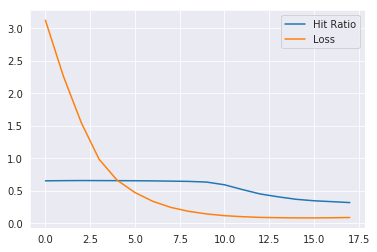

In [25]:
sns.set_style('darkgrid')
plt.plot(hr_list, label = 'Hit Ratio')
plt.plot(loss_list, label = 'Loss')
plt.legend()

In [26]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
mlp_embedding_user (Embedding)  (None, 1, 15)        5528970     user_input[0][0]                 
__________________________________________________________________________________________________
mlp_embedding_item (Embedding)  (None, 1, 15)        299820      item_input[0][0]                 
__________________________________________________________________________________________________
concatenat

# Implicit Feedback

### I've built my own implicit feedback model but it's hard to train, so I chose to use the API from other great minds. The API 'implicit' is based 100% by the paper I refer and written in cython and has good performance. 

In [19]:
!pip install implicit

In [19]:
nb_users = len(eruid_map.items())
nb_articles = len(pid_map.items())
uim = np.zeros((nb_users, nb_articles), dtype=np.float32)
uim[df_train_group_map.eruid, df_train_group_map.pid] = df_train_group_map.read_time ### Here comes the point that we only 
                                                                                     ### use the training data to make the
                                                                                     ### uim matrix

from scipy import sparse as sp
alpha = 195
uim = uim + uim * alpha
uim = sp.csr_matrix(uim.T) ### The API needs the rows to be items and the columns to be users 
print('uim shape : ',uim.shape)

from implicit.als import AlternatingLeastSquares

model = AlternatingLeastSquares(factors=15,use_gpu=False)
model.fit(item_users=uim)

assert(model.user_factors.shape[0] == len(eruid_map))
assert(model.item_factors.shape[0] == len(pid_map))

### Evaluating
topK = 5
evaluation_threads = 1
testRatings, testNegatives = test_rating_map, negative_test_rating_map
time1 = time()
(hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads,
                               eval_mode = 'ALS', uim = uim)
hr, ndcg = np.array(hits).mean(), np.array(ndcgs).mean()
print('HR = %.4f, NDCG = %.4f [%.1f s], alpha = %d' % (hr, ndcg, time()-time1, alpha))

  0%|          | 0/15 [00:00<?, ?it/s]

uim shape :  (19988, 368598)


100%|██████████| 15.0/15 [00:54<00:00,  3.17s/it]


HR = 0.7028, NDCG = 0.5361 [26.0 s], alpha = 195


### Below it my personal attempt on building the implicit recommendation model under Keras framework, the result is far from the API and still needs time to fine-tune and debugs
### In the paper, we need to transform the observation into confidence values, which includes two steps,
### 1. Transform all missing values(those unobserved user-item pairs) into 0
### 2. Customize the loss function into $\min \sum_{u,i}c_{ui}(p_{ui} - x_{u}^{T}y_{i})^{2} + \lambda  
(\sum_{u}||x_{u}||^2 + \sum_{i}||y_{i}||^2)$

In [ ]:
### 1. Transform all missing value

nb_users = len(eruid_map.items())
nb_articles = len(pid_map.items())
uim = np.zeros((nb_users, nb_articles), dtype=np.float32)
uim[df_train_group_map.eruid, df_train_group_map.pid] = df_train_group_map.read_time ### Here comes the point that we only 
                                                                                     ### use the training data to make the
                                                                                     ### uim matrix
### 2. Customize loss function

def Implicit_loss(alpha):
    
    def Loss_function(y_true, y_pred):
        c = 1 + alpha * y_true
#         Loss = K.mean(c * K.square(y_true - y_pred)) 
        Loss = c * K.square(y_true - y_pred) 
        ### The reason why we don't have to add the penalty term in 'Loss_function' is that we've done that in 'get_model' function,
        ### the attribute 'embedding_regularizer' needs a value that stands for l2 norm with that value.
        return Loss
        
    return Loss_function

def uim_gen(uim, batch_size, eruid_map, pid_map):
    row = [i for i in range(len(eruid_map))] * (len(pid_map) // 10)

    col = [i for i in range(len(pid_map))] * (len(eruid_map) // 10)
    
    while True:
        user_input_vector = np.array(random.sample(row,batch_size))
        item_input_vector = np.array(random.sample(col,batch_size))
        labels_vector = uim[user_input_vector,item_input_vector]
        yield ([user_input_vector,item_input_vector],labels_vector)

def get_model(num_users, num_items, latent_dim, regs=[0,0]):
    ### define placeholder.
    user_id_input = Input(shape=[1], name='user')
    item_id_input = Input(shape=[1], name='item')

    ### define embedding size and layers.

    user_embedding = Embedding(output_dim = latent_dim, input_dim = num_users,
                               input_length=1, name='user_embedding',
                               embeddings_regularizer = l2(regs[0]))(user_id_input)
    item_embedding = Embedding(output_dim = latent_dim, input_dim = num_items,
                               input_length=1, name='item_embedding',
                              embeddings_regularizer = l2(regs[1]))(item_id_input)

    user_vecs = Reshape([latent_dim])(user_embedding)
    item_vecs = Reshape([latent_dim])(item_embedding)

    ### The prediction, which we calculate the loss function with ground truth and optimize.
    y_hat = Dot(1, normalize=False)([user_vecs, item_vecs])

    model = Model(inputs=[user_id_input, item_id_input], outputs=y_hat)
    
    return model

### parameter setting&start training

num_users = len(eruid_map.items())
num_items = len(pid_map.items())
topK = 5
verbose = 0
latent_dim = 15
epochs = 100
batch_size = 1024 * 1024
evaluation_threads = 1
best_hr, best_ndcg, best_iter = -1, -1, -1
model_out_file = 'models/GMF_%d_%d.h5' %(latent_dim, time())
testRatings, testNegatives = test_rating_map, negative_test_rating_map
learning_rate = 0.01
alpha = 120
model = get_model(num_users, num_items, latent_dim, regs=[0,0])
model.compile(optimizer=Adam(lr=learning_rate), loss=Implicit_loss(alpha = alpha)) ### In this task, for label is 'read times'(integers from 0 -> 3XXX), so we use MSE as loss to optimize,
                                                            ### However, if there is 'read or not-read'(integers 0 and 1), we should use 'binary cross-entropy'
                                                            ### P.S. If using 'binary cross-entropy' in 'read times' task, I get the weird result with negative l
hr_list = []
loss_list = []
patience = 5
early_stop =True


# Generate training instances
gen = uim_gen(uim, batch_size, eruid_map, pid_map)


for epoch in range(epochs):
    t1 = time()
        
    # Training
    hist = model.fit_generator(gen,
                         steps_per_epoch = (len(eruid_map) * len(pid_map)) // batch_size ,
                         validation_data = ( [df_test_group_map.eruid,df_test_group_map.pid],df_test_group_map.read_time) ,
                         epochs = 1, verbose = verbose, shuffle = True)
    t2 = time()
        
    # Evaluation
    (hits, ndcgs) = evaluate_model(model, testRatings, testNegatives, topK, evaluation_threads)
    hr, ndcg, loss = np.array(hits).mean(), np.array(ndcgs).mean(), hist.history['val_loss'][0]    
    hr_list.append(hr)
    loss_list.append(loss)
    # Using patience to set the early stopping.
    # Always to save the model with minimun loss.
    if hr < np.max(hr_list):
        patience_count += 1
    else:
        patience_count = 0
        best_hr, best_ndcg, best_iter = hr, ndcg, epoch
        model.save_weights(model_out_file, overwrite=True)
    if (early_stop) and (patience_count == patience):
        break
    if epoch % 1 == 0:
        print('Iteration %d [%.1f s]: HR = %.4f, NDCG = %.4f, val_loss = %.4f [%.1f s]' 
            % (epoch,  t2-t1, hr, ndcg, loss, time()-t2))
        
print("End. Best Iteration %d:  HR = %.4f, NDCG = %.4f. " %(best_iter, best_hr, best_ndcg))